### PS3

Li Liu

5/24/19


In [157]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time

#### Ex 2.1

In [158]:
A = 1 #productivity scale parameter
alpha = 0.35 #capital share of income
beta = 0.442 #20-year discount factor
delta = 0.6415 # 20-year depreciation rate
sigma = 3 #relative risk aversion
labor = np.array([1, 1, 0.2]) #labor supply of three periods
SS_tol = 1e-9 #error tolerance
f_params = (labor, A, alpha, delta) #tuple of input parameters

In [159]:
get_r = lambda K, L, alpha, delta, A : A * alpha * ((L / K) ** (1 - alpha)) - delta
get_w = lambda K, L, alpha, A: A * (1 - alpha) * ((K / L) ** alpha)
get_K = lambda b2, b3: b2+b3
get_cons = lambda b_s, b_s_1, n_s, r, w: w * n_s + (1 + r) * b_s - b_s_1
get_util = lambda c, sigma=3: (c ** (1-sigma))/(1-sigma)
get_MU = lambda c, sigma=3: c ** (-sigma)
get_Y = lambda K, L, alpha, A: A * (K ** alpha) * (L ** (1-alpha))

In [160]:
def feasible(f_params, bvec_guess):
    labor, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = b2 + b3
    L = np.sum(labor)
    r = get_r(K, L, alpha, delta, A)
    w = get_w(K, L, alpha, A)
    
    c1 = get_cons(0, b2, labor[0], r, w)
    c2 = get_cons(b2, b3, labor[1], r, w)
    c3 = get_cons(b3, 0, labor[2], r, w)
    
    b_cnstr = np.zeros(2, dtype = 'bool')
    c_cnstr = np.zeros(3, dtype = 'bool')
    K_cnstr = ((b2 + b3)<=0)
    
    c_cnstr[0], c_cnstr[1], c_cnstr[2] = (c1<=0), (c2<=0), (c3<=0)
    
    if c_cnstr[0]:
        b_cnstr[0] = 1
    if c_cnstr[1]:
        b_cnstr[0], b_cnstr[1] = 1, 1
    if c_cnstr[2]:
        b_cnstr[1] = 1
        
    return b_cnstr, c_cnstr, K_cnstr

##### a. the constraints in period 1 is violated

In [161]:
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [ True False]
c_cnstr: [ True False False]
K_cnstr: False


##### b. no constraint is violated

In [162]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [False False]
c_cnstr: [False False False]
K_cnstr: False


##### c. no constraint is violated

In [163]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, bvec_guess)
print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [False False]
c_cnstr: [False False False]
K_cnstr: False


#### Ex 2.2

In [164]:
def EulEqs(bvec, f_params):
    labor, A, alpha, delta, beta = f_params
    b2, b3 = bvec
    L = labor.sum()
    K = get_K(b2, b3)
    r = get_r(K, L, alpha, delta, A)
    w = get_w(K, L, alpha, A)
    c1 = get_cons(0, b2, labor[0], r, w)
    c2 = get_cons(b2, b3, labor[1], r, w)
    c3 = get_cons(b3, 0, labor[2], r, w)
    MU1, MU2, MU3 = get_MU(c1), get_MU(c2), get_MU(c3)
    Eul1 = MU1 - beta*(1+r) * MU2
    Eul2 = MU2 - beta*(1+r) * MU3
    return np.array([Eul1, Eul2])

In [165]:
def get_SS(params, bvec_guess, SS_graphs = False):
    start_time = time.clock()
    beta, sigma, labor, L, A, alpha, delta, SS_tol = params
    f_params = np.array([labor, A, alpha, delta, beta])
    b_ss = opt.root(EulEqs, bvec_guess, args = (f_params)).x
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(K_ss, L, alpha, delta, A)
    Y_ss = get_Y(K_ss, L, alpha, A)
    w_ss = get_w(K_ss, L, alpha, A)
    c1 = get_cons(0, b2, labor[0], r_ss, w_ss)
    c2 = get_cons(b2, b3, labor[1], r_ss, w_ss)
    c3 = get_cons(b3, 0, labor[2], r_ss, w_ss)
    c_ss = np.array([c1, c2, c3])
    C_ss = c_ss.sum()
    EulErr_ss = EulEqs(b_ss, f_params)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    ss_time = time.clock() - start_time
    ss_output = {
    'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
    'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    
    if SS_graphs:
        plt.style.use('ggplot')
        fig, ax = plt.subplots()
        ax.plot(np.arange(1,4), c_ss, marker = 'o', label = 'consumptions')
        ax.plot(np.arange(2,4), b_ss, marker = 'o', label = 'savings')
        ax.legend()
        ax.set_title('Steady-state Distribution of Consumptions and Savings by Age')
        plt.show()
        
    return ss_output

#### a. solve for equilibrium values

In [166]:
params = [beta, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess)

In [167]:
print('Steady-state equilibrium values for savings are',ss_output['b_ss'])
print('Steady-state equilibrium values for consumptions are',ss_output['c_ss'])
print('Steady-state equilibrium value for wage is',ss_output['w_ss'])
print('Steady-state equilibrium value for interest rate is',ss_output['r_ss'])
print('Steady-state equilibrium value for capital is',ss_output['K_ss'])
print('Steady-state equilibrium value for output is',ss_output['Y_ss'])
print('Steady-state equilibrium value for total consumption is',ss_output['C_ss'])
print('Steady-state equilibrium values for Euler errors are',ss_output['EulErr_ss'])
print('Steady-state equilibrium value for resource constraint error is',ss_output['RCerr_ss'])
print()
print('Time to compute steady-state equilibrium is', round(ss_output['ss_time'], 6), 'seconds')

Steady-state equilibrium values for savings are [0.01931253 0.0584111 ]
Steady-state equilibrium values for consumptions are [0.18241213 0.20961468 0.24087387]
Steady-state equilibrium value for wage is 0.20172465739052575
Steady-state equilibrium value for interest rate is 2.433062339127069
Steady-state equilibrium value for capital is 0.07772362575316386
Steady-state equilibrium value for output is 0.6827603788602411
Steady-state equilibrium value for total consumption is 0.6329006729395864
Steady-state equilibrium values for Euler errors are [-1.39266376e-12  2.62900812e-12]
Steady-state equilibrium value for resource constraint error is 8.326672684688674e-17

Time to compute steady-state equilibrium is 0.014976 seconds


##### b. generate figure 

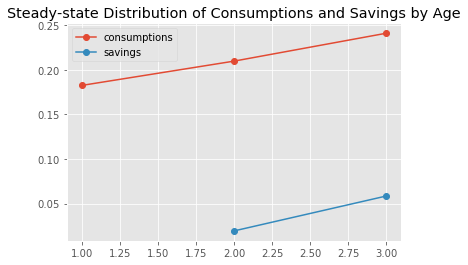

{'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'K_ss': 0.07772362575316386,
 'RCerr_ss': 8.326672684688674e-17,
 'Y_ss': 0.6827603788602411,
 'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'r_ss': 2.433062339127069,
 'ss_time': 0.0015887999998085434,
 'w_ss': 0.20172465739052575}

In [168]:
get_SS(params, bvec_guess, True)

#### c. larger beta

In [169]:
params2 = [0.55, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
ss_output2 = get_SS(params2, bvec_guess)
print('Steady-state equilibrium values for savings are',
      ss_output2['b_ss'], 'compared with previous', ss_output['b_ss'])
print('Steady-state equilibrium values for consumptions are',
      ss_output2['c_ss'], 'compared with previous', ss_output['c_ss'])
print('Steady-state equilibrium value for wage is',ss_output2['w_ss'],
      'compared with previous', ss_output['w_ss'])
print('Steady-state equilibrium value for interest rate is',ss_output2['r_ss'], 
      'compared with previous', ss_output['r_ss'])

Steady-state equilibrium values for savings are [0.02817692 0.07686545] compared with previous [0.01931253 0.0584111 ]
Steady-state equilibrium values for consumptions are [0.19597528 0.22861594 0.26669307] compared with previous [0.18241213 0.20961468 0.24087387]
Steady-state equilibrium value for wage is 0.22415219593446706 compared with previous 0.20172465739052575
Steady-state equilibrium value for interest rate is 1.8863765057189819 compared with previous 2.433062339127069


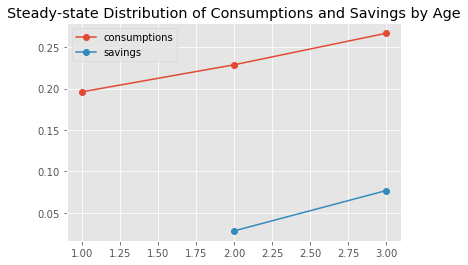

{'C_ss': 0.6912842903551526,
 'EulErr_ss': array([6.87805368e-12, 2.52953214e-12]),
 'K_ss': 0.1050423702259807,
 'RCerr_ss': 9.71445146547012e-17,
 'Y_ss': 0.7586689708551193,
 'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'r_ss': 1.8863765057189819,
 'ss_time': 0.003394999999727588,
 'w_ss': 0.22415219593446706}

In [170]:
get_SS(params2, bvec_guess, True)

For the new steady-state values, wage, saving and consumption increase, while the interest rate decreases.

Intuition: people save more given the same interest rate as the beta is larger. The interest rate decreases so that people are indifferent to saving and consuming. More savings lead to more firm capital, larger marginal productivity of labor, and higher wage. Thus, people consume more.

#### Ex 2.3

##### a.

In [171]:
def timepath(K_path_update, K_init, K_ss, T, A, alpha, delta, labor, m, Type):
    path = np.zeros([T + m, 4])
    period_path  = np.arange(1, T + m +1)
    if Type == "linear":
        K_path = np.linspace(K_init, K_ss, num = T)
    if Type == "update":
        K_path = K_path_update
    path[: , 0] = period_path
    path[: -m, 1] = K_path
    path[-m: , 1] = K_ss
    path[: , 2] = get_w(path[: , 1], labor.sum(), alpha, A)
    path[: , 3] = get_r(path[: , 1], labor.sum(), alpha, delta, A)
    return path

In [172]:
def EulErr(bvec, *args):
    w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor = args
    b2, b3 = bvec
    L = labor.sum()
    K = get_K(b2, b3)
    c1 = get_cons(0, b2, labor[0], r2, w1)
    c2 = get_cons(b2, b3, labor[1], r2, w2)
    c3 = get_cons(b3, 0, labor[2], r3, w3)
    MU1 = get_MU(c1)
    MU2 = get_MU(c2)
    MU3 = get_MU(c3)
    Eul1 = MU1 - beta*(1+r2) * MU2
    Eul2 = MU2 - beta*(1+r3) * MU3
    Euler_errs = np.array([Eul1, Eul2])
    return Euler_errs

In [173]:
def solve_path(path, *args):
    bvec_init_val, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init_val
    def get_b32(b32, *args):
        r2, r3, b21, w2, w3, beta, sigma, labor = args
        c2  = get_cons(b21, b32, labor[1], r2, w2)
        c3  = get_cons(b32, 0, labor[2], r3, w3)
        MU2 = get_MU(c2)
        MU3 = get_MU(c3)
        error =  MU2 - beta * (1 + r3) * MU3
        return error
    b32_init = 0.1
    b32_args  = (path[0 , 3], path[1 , 3], b_mat[0 , 0], path[0 , 2], path[1 , 2], beta, sigma, labor)
    b32 = opt.root(get_b32, b32_init, args = (b32_args))
    b32 = b32.x
    b_mat[1 , 1] = b32
    for i in range(path.shape[0]-2):
        w1 = path[i - 1 , 2]
        w2 = path[i , 2]
        w3 = path[i + 1 , 2]
        r2 = path[i , 3]
        r3 = path[i + 1, 3]
        ts_args = (w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor)
        bvec_ts = opt.root(EulErr, bvec_init, args = (ts_args))
        b_mat[i , 0] = bvec_ts.x[0]
        b_mat[i + 1, 1] = bvec_ts.x[1]
    b_mat[: , 2] = b_mat[: , 0] + b_mat[: , 1]
    return b_mat

In [174]:
def TPI(path_init, xival, tol, *args):
    bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init
    b_HH_init  = solve_path(path_init, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
    diff_init = sum(((path_init[: -m, 1] - b_HH_init[: -m, 2])/path_init[: -m, 1])**2)
    if diff_init > tol:
        '''
        if the initial epsilon is larger than the tolerance
        we update the time path and calculated time path and recalculate the epsilon
        '''
        path = path_init
        b_HH = b_HH_init
        diff = diff_init
        iter_num = 0
        while diff > tol:
            update = xival * b_HH[: -m, 2] + (1 - xival) * path[: -m, 1]
            path = timepath(update, 0, K_ss, T, A, alpha, delta, labor, m, "update")
            b_HH = solve_path(path, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
            diff = sum(((path[: -m, 1] - b_HH[: -m, 2])/path[: -m, 1])**2)
            iter_num = iter_num + 1
            print("iteration: ", iter_num, "       difference: ", diff)

        result = (path, b_HH)
    else:
        result =  (path_init, b_HH_init)
    return result

In [175]:
xival = 0.1
tol = 1e-9
bvec_init = np.array([0.8 * ss_output['b_ss'][0], 1.1 * ss_output['b_ss'][1]])
T = 25
m = 25
bvec_ss = ss_output['b_ss']
K_ss = ss_output['K_ss']
K_init = bvec_init.sum()
path_init = timepath(0, K_init, K_ss, T, A, alpha, delta, labor, m, "linear")

In [176]:
path = TPI(path_init, xival, tol,  bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss)


iteration:  1        difference:  0.0026923268543442274
iteration:  2        difference:  0.002157561740107381
iteration:  3        difference:  0.0017408174700849334
iteration:  4        difference:  0.0014142121894262733
iteration:  5        difference:  0.001156736568482737
iteration:  6        difference:  0.0009525098783005804
iteration:  7        difference:  0.0007894893845593586
iteration:  8        difference:  0.0006585123205853978
iteration:  9        difference:  0.0005525827671266743
iteration:  10        difference:  0.00046633946890379505
iteration:  11        difference:  0.0003956577161222008
iteration:  12        difference:  0.0003373508229514696
iteration:  13        difference:  0.00028894577394323863
iteration:  14        difference:  0.00024851422573664284
iteration:  15        difference:  0.0002145449103690303
iteration:  16        difference:  0.00018584706684335225
iteration:  17        difference:  0.00016147717292832263
iteration:  18        difference:  0.

In [177]:
K_path = path[0][:, [0 , 1]]
w_path = path[0][:, [0 , 2]]
r_path = path[0][:, [0 , 3]]
b_path = path[1][:,:2]

In [178]:
Eulerr_path = np.zeros((30, 2))
RCerr_path = np.zeros(30)
for i in range(30):
    if i == 0:
        rt = rt1 = r_path[0,1]
        wt = wt1 = w_path[0,1]
        b2t = b2t1 = b_path[0, 0]
        b3t = b3t1 = b_path[0, 1]
    else:
        rt, rt1 = r_path[i, 1], r_path[i-1, 1]
        b2t, b3t = b_path[i,:]
        b2t1, b3t1 = b_path[i-1, :]
        wt, wt1 = w_path[i,1], w_path[i-1, 1]
    Kt = K_path[i,1]
    Kt_1 = K_path[i+1, 1]
    Yt = get_Y(Kt, labor.sum(), alpha, A)
    c1t = get_cons(0, b2t, labor[0], rt, wt)
    c2t = get_cons(b2t1, b3t, labor[1], rt1, wt)
    c3t = get_cons(b3t1, 0, labor[2], rt1, wt)
    Ct = c1t + c2t + c3t
    RCerr_path[i] = Yt - Ct - Kt_1 + (1 - delta) * Kt
    Eulerr_path[i, :] = EulErr(b_path[i, :], w_path[i,1], w_path[i+1,1], 
                               w_path[i+2,1], r_path[i+1,1], r_path[i+2,1], 
                               beta, alpha, delta, sigma, A, labor)

In [179]:
print('Maximum of the absolute values of all the Euler errors across the entire time path is', 
      np.abs(Eulerr_path).max())
print('Maximum of the absolute values of all the resource constraint errors across the entire time path is', 
      np.abs(RCerr_path).max())

Maximum of the absolute values of all the Euler errors across the entire time path is 37.40392775466471
Maximum of the absolute values of all the resource constraint errors across the entire time path is 0.005773427692391937


##### b. 

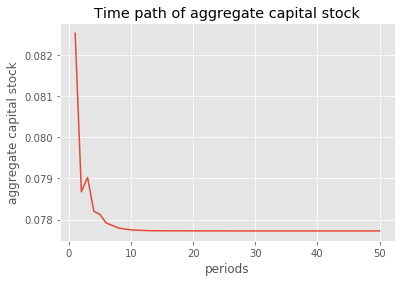

In [180]:
K_fig = plt.figure()
plt.plot(K_path[: , 0], K_path[: , 1])
plt.xlabel('periods')
plt.ylabel('aggregate capital stock')
plt.title('Time path of aggregate capital stock')
plt.show()

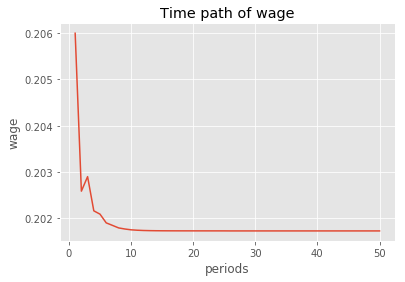

In [181]:
w_fig = plt.figure()
plt.plot(w_path[: , 0], w_path[: , 1])
plt.xlabel('periods')
plt.ylabel('wage')
plt.title('Time path of wage')
plt.show()

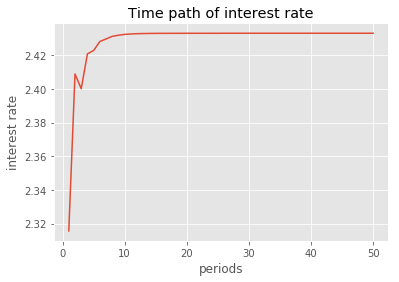

In [182]:
r_fig = plt.figure()
plt.plot(r_path[: , 0], r_path[: , 1])
plt.xlabel('periods')
plt.ylabel('interest rate')
plt.title('Time path of interest rate')
plt.show()

##### c.

In [183]:
for i in range(50):
    K = K_path[i, 1]
    if abs(K - K_ss) <= 0.00001:
        print('Time to get within 0.00001 of the steady-state aggregate capital stock: {} periods '.format(int(K_path[i, 0])))
        break

Time to get within 0.00001 of the steady-state aggregate capital stock: 13 periods 


In [184]:
for i in range(50):
    K_mat = K_path[i:, 1]
    Diff = np.abs(K_mat - K_ss)
    if np.sum(Diff > 0.00001) == 0:
        print(" After period {}, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.".format(int(K_path[i, 0])))
        break

 After period 13, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.
